## Pre-Process GPS DATA

In [40]:
import numpy as np
import pandas as pd 
import os 
import fnmatch
import json
from tqdm import tqdm
import datetime as dt 
from matplotlib import pyplot as plt 
import pyproj 
from multiprocessing.pool import Pool

geod = pyproj.Geod(ellps='WGS84')


In [41]:
LABELS_FILE = 'labels.txt'
MAIN_FOLDER = '/home/tandonsa/PycharmProjects/side_project/GPS_dataAnalysis/geolife_trajectories/Data'
TRAJ_FOLDER = 'Trajectory/'
OUTPUT_FOLDER = '/home/tandonsa/PycharmProjects/side_project/GPS_dataAnalysis/geolife_trajectories/Processed_data'
POOLSIZE = 10

headers_trajectory = ['lat', 'long', 'null', 'altitude','timestamp_float', 'date', 'time']

In [42]:
geo_data = list()
for root,dirs,files in os.walk(MAIN_FOLDER):
    for basename in files:
        if fnmatch.fnmatch(basename, '*.plt'):
            filename = os.path.join(root,basename)
            geo_data.append(filename)
            
geo_data.sort()
print("Total individual trajectory :{}".format(len(os.listdir(MAIN_FOLDER))))
print("Total number of trajectory files:{}".format(len(geo_data)))

Total individual trajectory :182
Total number of trajectory files:18670


In [43]:
def calculate_distance(long1,lat1,long2,lat2):
    if lat1==lat2 and long1==long2:
        return 0
    if False in np.isfinite([long1, long2, lat1, lat2]):
        return np.nan
    if lat1 < -90 or lat1 > 90 or lat2 < -90 or lat2 > 90:
        #raise ValueError('The range of latitudes seems to be invalid.')
        return np.nan
    if long1 < -180 or long1 > 180 or long2 < -180 or long2 > 180:
        return np.nan
    angle1,angl2,distance = geod.inv(long1,lat1,long2,lat2)
    return distance

def calculate_velocity(distance,time_delta):
    if time_delta.total_seconds() == 0: return np.nan
    return distance/time_delta.total_seconds()

def calculate_accelartion(v,v_next,time_delta):
    if time_delta.total_seconds() == 0: return np.nan
    v_delta = v_next-v
    return v_delta/time_delta.total_seconds()

In [44]:
def read_plt_data(plt_file,skip_lines=6):
    with open (plt_file,'r+') as tfd:
        data = tfd.readlines()
    data = [txt.strip() for txt in data]
    return data[skip_lines:]

def create_gps_dataframe(list_data):
    df = pd.DataFrame([val.split(",") for val in list_data],columns=headers_trajectory)
    return df

def to_datetime(string):
    return dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

def load_trajectory(data_filename):
    data = read_plt_data(data_filename)
    # create gps_data_frame
    gps_df = create_gps_dataframe(data)
    # get subfolder 
    gps_df['subdir']= data_filename.split('/')[-3]
    # get trajectory ID 
    gps_df['trajectory_id'] = data_filename.split('/')[-1].split('.')[0]
    
    gps_df['datetime'] = gps_df.apply(lambda z: to_datetime(z.date + ' ' + z.time), axis=1)
    gps_df['datetime_next_position'] = gps_df['datetime'].shift(-1)
    gps_df['time_delta'] = gps_df.apply(lambda z: z.datetime_next_position-z.datetime,axis=1)
    gps_df = gps_df.drop(['null', 'timestamp_float', 'date', 'time','datetime_next_position'], axis=1)
    
    # longitudnal next position 
    gps_df['long_next_position'] = gps_df['long'].shift(-1)
    gps_df['lat_next_position'] = gps_df['lat'].shift(-1)
    gps_df['distance'] = gps_df.apply(lambda z: calculate_distance(float(z.long), float(z.lat), float(z.long_next_position), float(z.lat_next_position)), axis=1)
    gps_df = gps_df.drop(['long_next_position', 'lat_next_position'], axis=1)
    
    # get velocity parameter
    gps_df['velocity'] = gps_df.apply(lambda z: calculate_velocity(float(z.distance), z.time_delta), axis=1)
    gps_df['velocity_next_position'] = gps_df['velocity'].shift(-1)
    gps_df['accelration'] = gps_df.apply(lambda z: calculate_accelartion(float(z.velocity),float(z.velocity_next_position),z.time_delta),axis=1)
    gps_df = gps_df.drop(['velocity_next_position'],axis=1)
    return gps_df
    

In [ ]:
LABELS_FILE = 'labels.txt'
for trajectory_dir in tqdm(os.listdir(MAIN_FOLDER)):
    base_dir = os.path.join(MAIN_FOLDER,trajectory_dir,TRAJ_FOLDER)
    list_df_traj = []
    for plt_files in os.listdir(base_dir):
        plt_fname = os.path.join(base_dir,plt_files)
        outfname = os.path.join(OUTPUT_FOLDER,trajectory_dir+'_gps.csv')
        list_df_traj.append(load_trajectory(plt_fname))
    # concat all the Data frame for id's
    df_traj_all = pd.concat(list_df_traj)
    df_traj_all.to_csv(outfname,index=False,header=False)
    list_df_traj = []
    
    if LABELS_FILE in os.listdir(os.path.join(MAIN_FOLDER,trajectory_dir):
        filename = subfolder_ + LABELS_FILE
        df_labels = load_labels_df(filename)
        for idx in df_labels.index.values:
            st = df_labels.ix[idx]['start_time']
            et = df_labels.ix[idx]['end_time']
            labels = df_labels.ix[idx]['labels']
            if labels:
                df_traj_all.loc[(df_traj_all['datetime'] >= st) & 
                                (df_traj_all['datetime'] <= et), 'labels'] = labels

print("Processed files are {}".format(len(os.listdir(OUTPUT_FOLDER))))

## Read Full CSV by concatenating the entire index'd files 

In [45]:
gps_df_all = pd.read_csv(os.path.join(os.path.dirname(MAIN_FOLDER),'dataset_raw_full.csv'))
print("Data frame Rows: ",gps_df_all.shape[0])
gps_df_all.head()
# gps_df_all.to_csv(os.path.joino(MAIN_FOLDER,'all_gps.csv'))

Data frame Rows:  3387303


Latitude  Longitude  Altitude            Date_Time  Id_user  \
0  41.741415  86.186028    -777.0  2008-03-31 16:00:08       10   
1  41.737063  86.179470    -777.0  2008-03-31 16:01:07       10   
2  41.734105  86.172823    -777.0  2008-03-31 16:02:07       10   
3  41.739110  86.166563    -777.0  2008-03-31 16:03:06       10   
4  41.744368  86.159987    -777.0  2008-03-31 16:04:05       10   

              Id_perc Label  
0  20080331160008.plt  taxi  
1  20080331160008.plt  taxi  
2  20080331160008.plt  taxi  
3  20080331160008.plt  taxi  
4  20080331160008.plt  taxi

In [ ]:
# calculate time difference between each time stamp
gps_df_all['Date_Time'] = gps_df_all.apply(lambda z: to_datetime(z.Date_Time), axis=1)
gps_df_all['datetime_next_position'] = gps_df_all['Date_Time'].shift(-1)
gps_df_all['time_delta'] = gps_df_all.apply(lambda z: z.datetime_next_position-z.Date_Time,axis=1)
gps_df_all = gps_df_all.drop(['datetime_next_position'],axis=1)

In [ ]:
# get distance between two points 
gps_df_all['long_next_position'] = gps_df_all['Longitude'].shift(-1)
gps_df_all['lat_next_position'] = gps_df_all['Latitude'].shift(-1)
gps_df_all['distance'] = gps_df_all.apply(lambda z: calculate_distance(float(z.Longitude), float(z.Latitude), float(z.long_next_position), float(z.lat_next_position)), axis=1)
gps_df_all = gps_df_all.drop(['long_next_position', 'lat_next_position'], axis=1)


In [ ]:
# get velocity parameter
gps_df_all['velocity'] = gps_df_all.apply(lambda z: calculate_velocity(float(z.distance), z.time_delta), axis=1)
gps_df_all['velocity_next_position'] = gps_df_all['velocity'].shift(-1)
gps_df_all['accelration'] = gps_df_all.apply(lambda z: calculate_accelartion(float(z.velocity),float(z.velocity_next_position),z.time_delta),axis=1)
gps_df_all = gps_df_all.drop(['velocity_next_position'],axis=1)


In [46]:
out_path = os.path.join(os.path.dirname(MAIN_FOLDER),'dataset_raw_full_processed.csv')

In [ ]:
gps_df_all = gps_df_all.sort_values('Id_user')
gps_df_all.head()

In [ ]:
gps_df_all.to_csv(out_path,index=False)

## Visualization
Give a box in geographical coordinates (latitude/longitude) and a zoom level, Smopy returns an OpenStreetMap tile image!

In [47]:
import smopy
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage
import imageio
import seaborn as sns

In [48]:
%time gps_df = pd.read_csv(out_path, parse_dates=['Date_Time'])
gps_df.head()

CPU times: user 4.43 s, sys: 356 ms, total: 4.78 s
Wall time: 5.18 s


Latitude  Longitude  Altitude           Date_Time  Id_user  \
0  41.741415  86.186028    -777.0 2008-03-31 16:00:08       10   
1  34.173700  92.395516   14951.0 2008-10-01 01:12:56       10   
2  34.173498  92.395371   14951.0 2008-10-01 01:12:57       10   
3  34.173298  92.395221   14948.0 2008-10-01 01:12:58       10   
4  34.173098  92.395073   14948.0 2008-10-01 01:12:59       10   

              Id_perc  Label       time_delta    distance   velocity  \
0  20080331160008.plt   taxi  0 days 00:00:59  728.881332  12.353921   
1  20080930203247.plt  train  0 days 00:00:01   26.091914  26.091914   
2  20080930203247.plt  train  0 days 00:00:01   26.142568  26.142568   
3  20080930203247.plt  train  0 days 00:00:01   26.045509  26.045509   
4  20080930203247.plt  train  0 days 00:00:01   26.576142  26.576142   

   accelration  
0    -0.027689  
1     0.050653  
2    -0.097058  
3     0.530633  
4     0.704285

walk        972671
bus         756878
bike        702384
car         388238
train       210267
subway      188648
taxi        157175
airplane      5915
boat          3443
run           1684
Name: Label, dtype: int64


/home/tandonsa/anaconda3/envs/tf-2.4/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


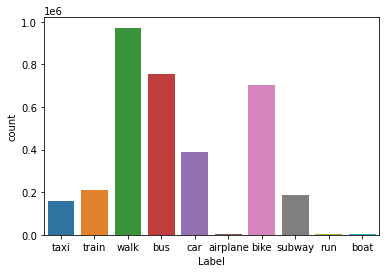

In [49]:
print(gps_df['Label'].value_counts())
sns.countplot(gps_df['Label'])

## Plot the Co-ordinates

In [50]:
smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png"
smopy.TILE_SIZE = 64

latMin = min(gps_df.Latitude)
latMax = max(gps_df.Latitude)
longMin = min(gps_df.Longitude)
longMax = max(gps_df.Longitude)

<Figure size 720x1080 with 0 Axes>

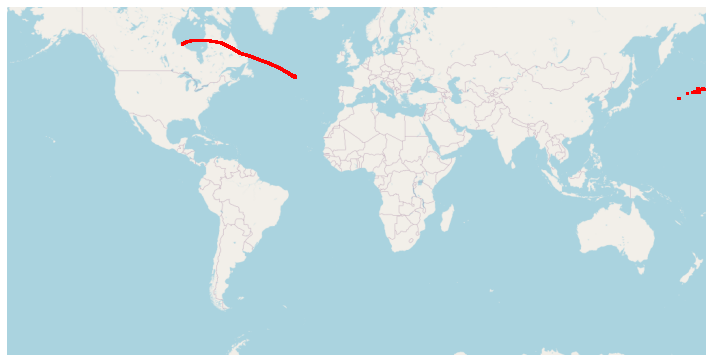

In [51]:
plt.figure(figsize=(10,15))
mapAll = smopy.Map((latMin, longMin, latMax, longMax ), z=2)
x, y = mapAll.to_pixels(gps_df.Latitude, gps_df.Longitude)
ax = mapAll.show_mpl(figsize=(10,7))
ax.plot(x, y, 'or', ms=2)

In [ ]:
latMinB = 39.64
latMaxB = 40.51
longMinB = 115.76
longMaxB = 116.88
mapBeijing = smopy.Map((latMinB, longMinB, latMaxB, longMaxB ), z=9)
mapBeijing.show_ipython()

In [53]:
gps_df['xPixel'] = mapBeijing.to_pixels(gps_df.Latitude, gps_df.Longitude)[0]
gps_df['yPixel'] = mapBeijing.to_pixels(gps_df.Latitude, gps_df.Longitude)[1]
dfBeijing = gps_df[(gps_df.Latitude.between(latMinB, latMaxB)) & (gps_df.Longitude.between(longMinB, longMaxB))]
dfBeijing.head()

Latitude   Longitude  Altitude           Date_Time  Id_user  \
31841  39.884961  116.368336     154.0 2008-09-25 00:15:01       10   
31842  39.884970  116.368336     154.0 2008-09-25 00:15:02       10   
31843  39.885203  116.368383     164.0 2008-09-25 00:16:15       10   
31844  39.885249  116.368388     167.0 2008-09-25 00:16:16       10   
31845  39.885303  116.368391     171.0 2008-09-25 00:16:17       10   

                  Id_perc Label       time_delta   distance  velocity  \
31841  20080924231334.plt  taxi  0 days 00:00:01   0.999292  0.999292   
31842  20080924231334.plt  taxi  0 days 00:01:13  26.181059  0.358645   
31843  20080924231334.plt  taxi  0 days 00:00:01   5.125367  5.125367   
31844  20080924231334.plt  taxi  0 days 00:00:01   6.001240  6.001240   
31845  20080924231334.plt  taxi  0 days 00:00:01   6.329426  6.329426   

       accelration      xPixel      yPixel  
31841    -0.640647  384.418156  523.757623  
31842     0.065298  384.418156  523.753353  
31843     0.875873  384.435268  523.642797  
31844     0.328187  384.437089  523.620971  
31845     1.054230  384.438181  523.595349

## Create self Color map 

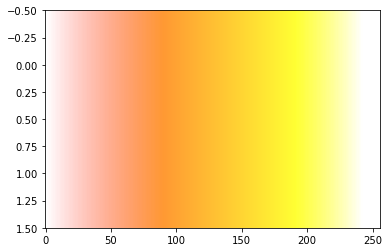

In [54]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, (1,0,0,0)), (0.35, (1,0.5,0,0.8)), (0.75, (1,1,0,0.8)), (0.95, (1,1,1,1)), (1, (1,1,1,1))])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap=cmap)

## Adding Heat map of GPS data to Satellite -MAP 

In [55]:
def heatMap(long, lat, area, bins=200, smoothing=1, vmax=4, title=None):
    x = area.to_pixels(lat, long)[0]
    y = area.to_pixels(lat, long)[1]
    
    ax = area.show_mpl(figsize=(12, 10))
    
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    output = ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=vmax)
    if title:
        ax.set_title(title, size=25)
        plt.savefig(title+'.png', bbox_inches='tight')
    print(np.amax(logheatmap))
    return output

latMinB = 39.64
latMaxB = 40.51
longMinB = 115.76
longMaxB = 116.88
mapZoom = smopy.Map((latMinB, longMinB, latMaxB, longMaxB ), z=15)

Lowered zoom level to keep map size reasonable. (z = 9)


/home/tandonsa/anaconda3/envs/tf-2.4/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


9.044862207552603


<Figure size 360x504 with 0 Axes>

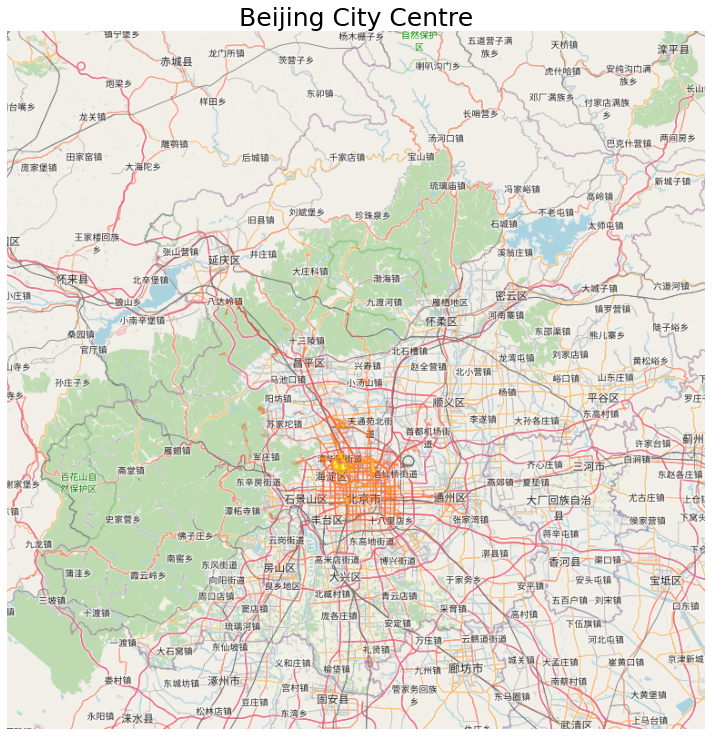

In [56]:
plt.figure(figsize=(5,7))
heatMap(dfBeijing.Longitude, dfBeijing.Latitude, mapZoom, bins=800, vmax=10, title='Beijing City Centre')

## Roads 

/home/tandonsa/anaconda3/envs/tf-2.4/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


7.056418022832535


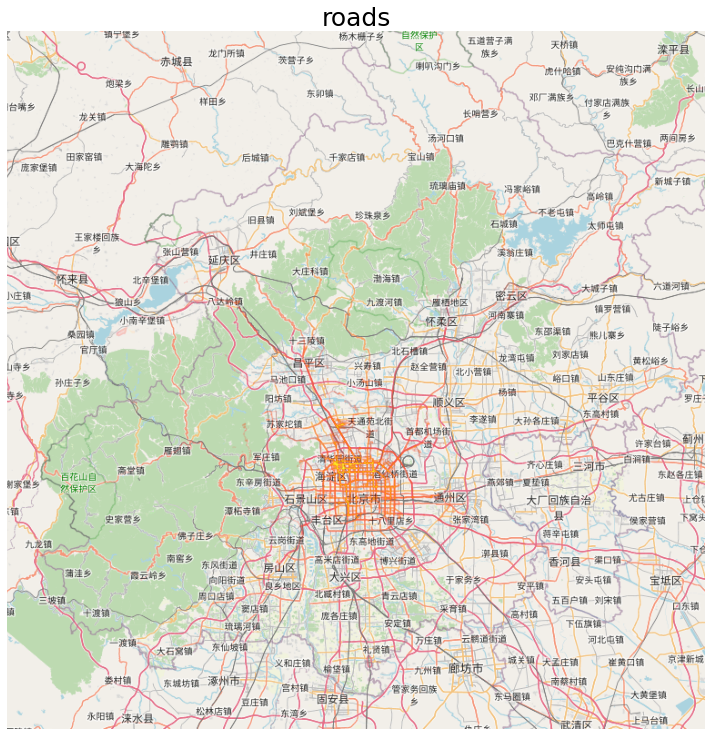

In [57]:
dfRoads = dfBeijing[dfBeijing['Label'].isin(['car', 'bus', 'taxi'])]
heatMap(dfRoads.Longitude, dfRoads.Latitude, mapZoom, bins=800, vmax=8, title='roads')

### Walking Areas 

/home/tandonsa/anaconda3/envs/tf-2.4/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


8.166610945187914


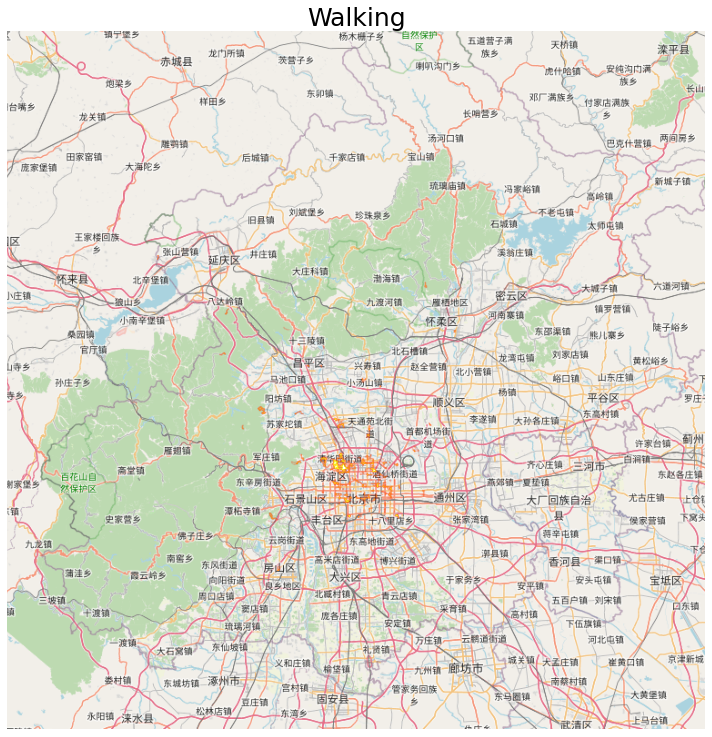

In [58]:
dfWalking = dfBeijing[dfBeijing['Label'] == 'walk']
heatMap(dfWalking.Longitude, dfWalking.Latitude, mapZoom, bins=800, vmax=7, title='Walking')

## BUS

Lowered zoom level to keep map size reasonable. (z = 9)


/home/tandonsa/anaconda3/envs/tf-2.4/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


6.214899595361873


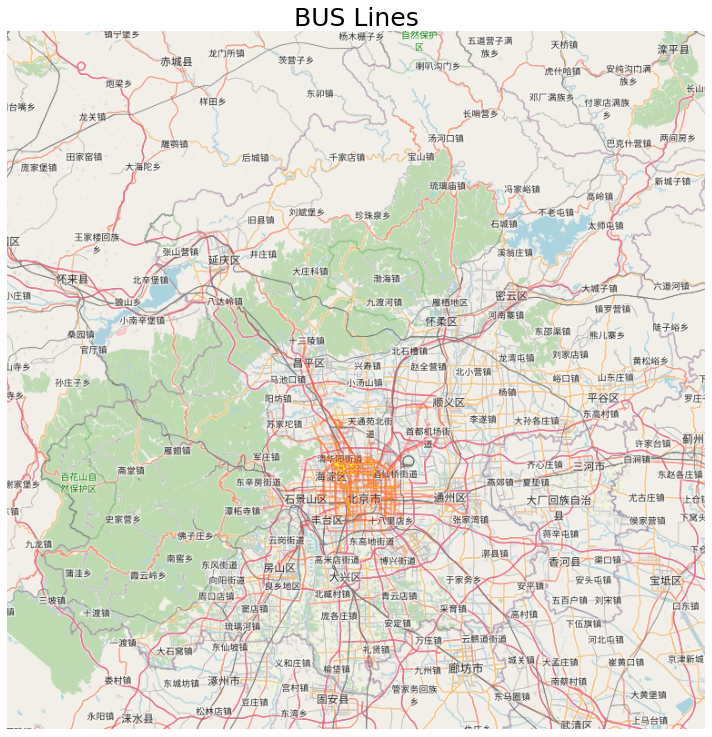

In [59]:
dfBus = dfBeijing[dfBeijing['Label'] == 'bus']

mapZoom = smopy.Map((latMinB, longMinB, latMaxB, longMaxB ), z=15)
heatMap(dfBus.Longitude, dfBus.Latitude, mapZoom, bins=800, vmax=7, title='BUS Lines')

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import geopy
from folium import plugins
from shapely.geometry import Point

loc_crs = {'init': 'epsg:4326'}

city = "Bejing"
# get location
locator = geopy.geocoders.Nominatim(user_agent="My app") 
city = locator.geocode(city)
location = [city.latitude, city.longitude]
print(city, "\n[lat, long]:", location)

map_ = folium.Map(location=location, tiles="cartodbpositron",zoom_start=10)

def get_geometricdf(locations_df):
    return gpd.GeoDataFrame(locations_df, crs=loc_crs, geometry=gpd.points_from_xy(locations_df.Longitude, locations_df.Latitude, crs="EPSG:4326"))

def get_geometric_heatmap(geo_df):
    return  [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry] 


In [37]:
geo_df_bus = get_geometricdf(dfBus)
geo_heatmap_bus = get_geometric_heatmap(geo_df_bus)

# plot the route map  
plt.figure(figsize=(10,7))
geo_df_bus.plot()

### Heat map for BUS-Routes

In [ ]:
folium.plugins.HeatMap(geo_heatmap_bus).add_to(map_)
map_

## Heat map for Walking Routes

In [ ]:
geo_df_walk = get_geometricdf(dfWalking)
geo_heatmap_walk = get_geometric_heatmap(geo_df_walk)

folium.plugins.HeatMap(geo_heatmap_walk).add_to(map_)
map_

## Get Satellite image from MAP-BOX

This repo shows you how to extract satellite images using a CSV file that contains coordinates (latitude and longitude). The extracted images can be used for different machine learning tasks such as path loss prediction (Of course the coordinates would have to be around the same area).
* note: use https://github.com/thewati/ExtractSatelliteImagesFromCSV to create free account on www.mapbox.com.

## Save image as html and take screen shot 
The website is saved and we ask python to take a screenshot via selinium package
* note: conda install -c conda-forge geckodriver - if Path error exsist

In [ ]:
# get satellite image 
import folium
from PIL import Image
import io
import cv2
#set tile set
mapboxAccessToken = "pk.eyJ1Ijoic2FtYXJ0aHRhbmRvbjkxIiwiYSI6ImNrejlyOWY1NDBhMDEyb3MyZmR4aHJyN3QifQ.SRigmM7ISo9A5TFvT-knvQ"
mapboxTilesetId = 'mapbox.satellite'

m = folium.Map(
        location=[39.9042, 116.4074],
        zoom_start=16,
        tiles='https://api.tiles.mapbox.com/v4/' + mapboxTilesetId + '/{z}/{x}/{y}.png?access_token=' + mapboxAccessToken,
        attr='mapbox.com')
m.save('/tmp/image.html') #save as html file

#take screenshot of html page and save as .png file
img_data = m._to_png(4)
img = Image.open(io.BytesIO(img_data))
opencvImg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(13,15))
plt.title('Satellite image')
plt.imshow(opencvImg)

### Prediction - Modality

In [60]:
unique_labels = gps_df['Label'].unique()
print("Unique trajectories :",unique_labels)

Unique trajectories : ['taxi' 'train' 'walk' 'bus' 'car' 'airplane' 'bike' 'subway' 'run' 'boat']


In [61]:
#We can filter out single modal trajectories by taking the labels which do not contain a comma:
df_single_modality = gps_df[gps_df['Label'].isin(unique_labels)]
df_single_modality.head()

Latitude  Longitude  Altitude           Date_Time  Id_user  \
0  41.741415  86.186028    -777.0 2008-03-31 16:00:08       10   
1  34.173700  92.395516   14951.0 2008-10-01 01:12:56       10   
2  34.173498  92.395371   14951.0 2008-10-01 01:12:57       10   
3  34.173298  92.395221   14948.0 2008-10-01 01:12:58       10   
4  34.173098  92.395073   14948.0 2008-10-01 01:12:59       10   

              Id_perc  Label       time_delta    distance   velocity  \
0  20080331160008.plt   taxi  0 days 00:00:59  728.881332  12.353921   
1  20080930203247.plt  train  0 days 00:00:01   26.091914  26.091914   
2  20080930203247.plt  train  0 days 00:00:01   26.142568  26.142568   
3  20080930203247.plt  train  0 days 00:00:01   26.045509  26.045509   
4  20080930203247.plt  train  0 days 00:00:01   26.576142  26.576142   

   accelration        xPixel       yPixel  
0    -0.027689 -10604.624828  -369.408457  
1     0.050653  -8343.819241  3130.771498  
2    -0.097058  -8343.872034  3130.860393  
3     0.530633  -8343.926647  3130.948407  
4     0.704285  -8343.980533  3131.036421

In [62]:
#This method calculates the aggregated feature and 
#saves them in the original df as well as an metadata df.
v_ave = np.nanmean(df_single_modality['velocity'].values)
v_med = np.nanmedian(df_single_modality['velocity'].values)
v_max = np.nanmax(df_single_modality['velocity'].values)
v_std = np.nanstd(df_single_modality['velocity'].values)

a_ave = np.nanmean(df_single_modality['accelration'].values)
a_med = np.nanmedian(df_single_modality['accelration'].values)
a_max = np.nanmax(df_single_modality['accelration'].values)
a_std = np.nanstd(df_single_modality['accelration'].values)

df_single_modality.loc[:, 'v_ave'] = v_ave
df_single_modality.loc[:, 'v_med'] = v_med
df_single_modality.loc[:, 'v_max'] = v_max
df_single_modality.loc[:, 'v_std'] = v_std

df_single_modality.loc[:, 'a_ave'] = a_ave
df_single_modality.loc[:, 'a_med'] = a_med
df_single_modality.loc[:, 'a_max'] = a_max
df_single_modality.loc[:, 'a_std'] = a_std

In [63]:
## # split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X = df_single_modality[['v_ave','v_med','v_max','v_std','a_ave','a_med','a_max','a_std']]
y = df_single_modality['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Train Data: ",X_train.shape)
print("Lable -Train: ",Y_train.shape)

print("Test data:",X_test.shape)
print("Lable Test:",Y_test.shape)

Train Data:  (2371112, 8)
Lable -Train:  (2371112,)
Test data: (1016191, 8)
Lable Test: (1016191,)


In [64]:
# build the lightgbm model and test the predictions
from sklearn.metrics import accuracy_score
import lightgbm as lgb

clf = lgb.LGBMClassifier()
# train the LGBM classifier
clf.fit(X_train, Y_train)

# predict the results
y_pred=clf.predict(X_test)

accuracy=accuracy_score(y_pred, Y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test, y_pred)))

# print the scores on training and test set
print('Training set score: {:.4f}'.format(clf.score(X_train, Y_train)))

LightGBM Model accuracy score: 0.2871
Training set score: 0.2872


In [65]:
# grid search  hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Scores ~0.284 (without tuning and early stopping)
params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'mutliclass', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 'device':0,
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'auc_mu'}

# Create parameters to search
grid_params = {'learning_rate': [0.01], 'n_estimators': [8, 24],
               'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
               'objective': ['binary'], 'seed': [500],
               'colsample_bytree': [0.65, 0.75, 0.8], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
               'reg_lambda': [1, 2, 6]}

mod = lgb.LGBMClassifier(**params)

# To view the default model params:
mod.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'device', 'scale_pos_weight', 'num_class', 'metric'])

In [ ]:
# Create the grid
grid = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=2, n_jobs=-1)
# Run the grid
grid.fit(X_train, Y_train)

In [ ]:
print('Best score reached: {} with params: {} '.format(grid.best_score_, grid.best_params_))